In [19]:
import numpy as np
import pandas as pd
import scanpy as sc
import sys
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sbn 

sys.path.append("../../../../")

from packages.models.multistageot import MultistageOT
import packages.models.tools as tools

In [20]:
sc.__version__

'1.9.3'

In [24]:
################# Define paths: ################# 
DATA_PATH    = "../../../../data/real/paul2015/"
RESULTS_PATH = "../../../../results/real_data/paul2015/"
MODEL_PATH   = RESULTS_PATH + "saved_models/"

Load data

In [25]:
adata = sc.datasets.paul15()
adata.X = adata.X.astype("float64")

#Save a .csv:
#pd.DataFrame(adata.X, index=adata.obs.index, columns=adata.var_names).to_csv(DATA_PATH + "20250129_paul2015.csv") 
 
sc.pp.recipe_zheng17(adata)

#Save a .csv of processed data:
#pd.DataFrame(adata.X, index=adata.obs.index, columns=adata.var_names).to_csv(DATA_PATH + "20250129_paul2015_preprocessed.csv") 

/Users/magnus/.conda/envs/manuscript_1/lib/python3.9/site-packages/scanpy/datasets/_datasets.py:202: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['iroot'] = 840


# Compute PCA:

In [26]:
sc.tl.pca(adata, svd_solver="arpack")

Save PCA data:

In [27]:
#pd.DataFrame(adata.obsm['X_pca'], index=adata.obs.index).to_csv(DATA_PATH + "20250129_paul2015_pca.csv") 

# Compute nearest-neighbour graph

In [28]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=50)

In [29]:
sc.tl.umap(adata, random_state=123)

Save UMAP coordinates:

In [30]:
#pd.DataFrame(adata.obsm['X_umap'], index=adata.obs.index).to_csv(DATA_PATH + "20250129_paul2015_umap.csv") 

# Load pre-computed UMAP coordinates

We load the pre-computed UMAP coordinates used for the results in the manuscript (computed with sc.tl.umap)

In [62]:
embedding = pd.read_csv("../../../../data/real_data/paul2015/20250129_paul2015_umap.csv")
embedding = embedding.drop(columns=['Unnamed: 0'])
embedding.columns = ['umap_1', 'umap_2']
embedding.index = embedding.index.astype(str)

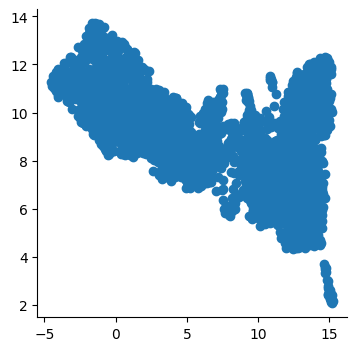

In [65]:
plt.figure(figsize=(4,4))
plt.scatter(embedding.loc[:,'umap_1'],embedding.loc[:,'umap_2'])
sbn.despine()

We flip the y-axis to make the orientation consistent with the embedding in Dahlin et al. (2018):

In [66]:
embedding['umap_2'] = -embedding['umap_2']

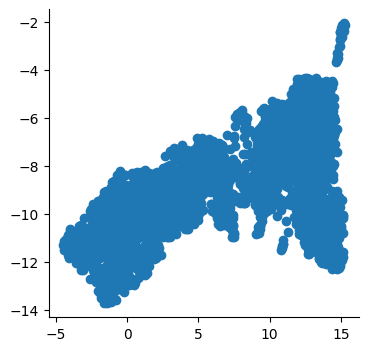

In [67]:
plt.figure(figsize=(4,4))
plt.scatter(embedding.loc[:,'umap_1'],embedding.loc[:,'umap_2'])
sbn.despine()

Define colors and lineage-associated marker genes for each mature cell type:

In [71]:
cell_types = ['Monocyte',
            'Lymphoid',
            'Meg',
            'Neutrophil',
            'Eos',
            'Baso',
            'Mast',
            'Erythroid', 'HSC']
 
gene_list = ['Ly86','Dntt','Pf4','Elane','Prg3','Prss34','Gzmb','Klf1','Mpl']

colors = np.array([[0,	111, 252], 
               [145, 254, 70],
               [30, 191, 193], 
               [208, 4, 38],
               [85, 50, 5],
               [254, 168, 64],
               [26, 136, 19],
               [251, 87, 252], [0,0,0]]) 

colors = colors/255

cell_type_colors = { cell_types[i] : colors[i] for i in range(len(cell_types)) }
lineage_associated_genes = { cell_types[i] : gene_list[i] for i in range(len(cell_types)) }


### Plotting lineage-associated gene markers

We graph a layered representation of all lineage-associated markers:

([], [])

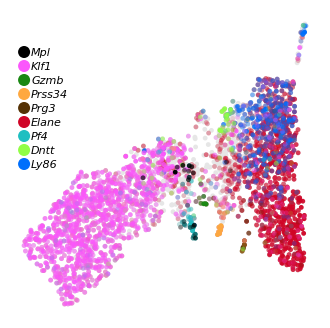

In [72]:
import matplotlib.font_manager as font_manager

font = font_manager.FontProperties(style='italic')

fig, ax = plt.subplots(figsize=(4,4))

annotation_colors = np.concatenate((colors, np.array([[0.1,0.1,0.1]])),axis=0)

zorder = [3,9,10,1,4,8,11,7,12]

data_z_scores = pd.DataFrame(adata.X, index=adata.obs.index, columns=adata.var_names)
data_z_scores = (data_z_scores - data_z_scores.mean()) / data_z_scores.std()

#Normalize embedding to unit square:
embedding_normalized = (embedding - embedding.min()) / (embedding.max() - embedding.min())

ax.scatter(embedding_normalized['umap_1'],embedding_normalized['umap_2'], facecolor=[0.9,0.9,0.9], edgecolor='none',s = 12,zorder=0) 

for i in range(len(gene_list)):
    
    gene_exp = data_z_scores[gene_list[i]]
    plot_order = gene_exp.sort_values(ascending=True).index
    gene_exp_sorted = gene_exp.loc[plot_order]
    
    alpha = (gene_exp_sorted - np.min(gene_exp_sorted) ) / (np.max(gene_exp_sorted) - np.min(gene_exp_sorted) )
    ax.scatter(embedding_normalized.loc[plot_order]['umap_1'],embedding_normalized.loc[plot_order]['umap_2'], s=12, alpha=alpha, facecolor=annotation_colors[i], edgecolor='none',zorder=zorder[i])
    ax.scatter(0,0.05*i+0.5, s=75,  facecolor=annotation_colors[i], edgecolor='none',zorder=zorder[i])

    #Plot gene names:
    ax.text(0.025,0.05*i-0.015+0.5, gene_list[i], fontproperties=font, fontsize=8)

sbn.despine(left=True, bottom=True)
plt.xticks([])
plt.yticks([])

We can also plot each lineage-associated marker separately:

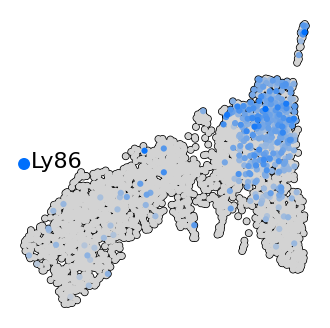

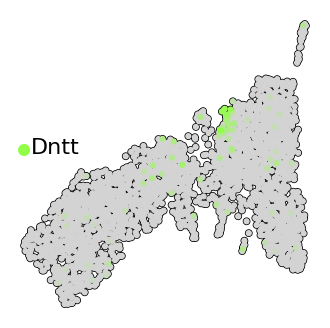

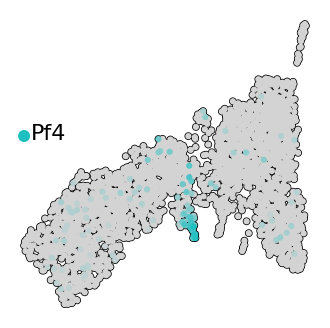

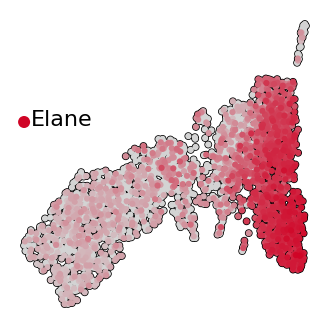

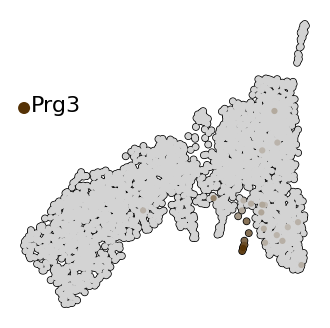

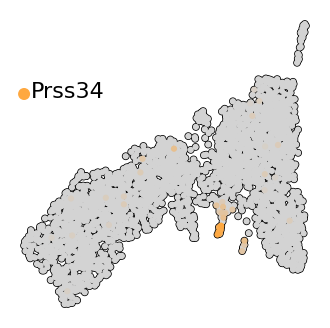

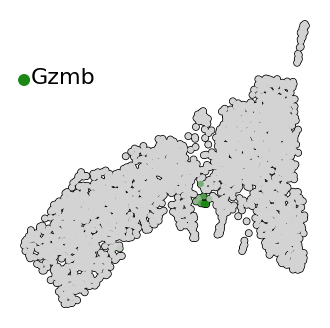

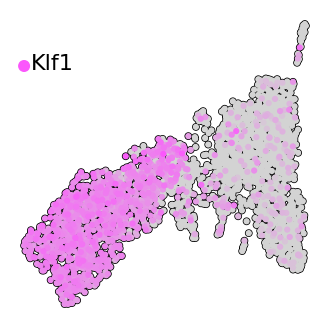

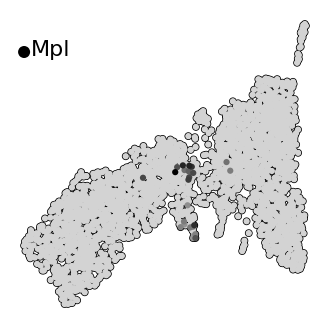

In [79]:
size = 12
zorder = [3,9,2,1,4,8,10,7,100]
#Normalize embedding to unit square:
for i in range(len(cell_types)):
        
    fig, ax = plt.subplots(figsize=(4,4))

    
    cell_type = cell_types[i]
    gene = lineage_associated_genes[cell_type]

    color_list = ['lightgrey', cell_type_colors[cell_type]]
    cmap_lineage = LinearSegmentedColormap.from_list("color_trial", colors=color_list) 

    ax.scatter(embedding_normalized['umap_1'],embedding_normalized['umap_2'], facecolor='none', edgecolor='k',s = 1.75*size,zorder=-1)
    ax.scatter(embedding_normalized['umap_1'],embedding_normalized['umap_2'], facecolor=[0.9,0.9,0.9], edgecolor='none',s = size,zorder=0) 

    annotation_colors = np.concatenate((colors, np.array([[0.1,0.1,0.1]])),axis=0)

    data_z_scores = pd.DataFrame(adata.X, index=adata.obs.index, columns=adata.var_names)
    data_z_scores = (data_z_scores - data_z_scores.mean()) / data_z_scores.std()

    gene_exp = data_z_scores[gene_list[i]] 
    plot_order = gene_exp.sort_values(ascending=True).index

    ax.scatter(embedding_normalized.loc[plot_order]['umap_1'],embedding_normalized.loc[plot_order]['umap_2'], s=20, c=gene_exp.loc[plot_order], cmap=cmap_lineage, edgecolor='none')
    ax.scatter(0,0.05*i+0.5, s=75,  facecolor=annotation_colors[i], edgecolor='none',zorder=zorder[i])
    ax.text(0.025,0.05*i-0.015+0.5, gene_list[i], fontsize=16)

    sbn.despine(left=True, bottom=True)
    plt.xticks([])
    plt.yticks([])

### Initial cells

In [80]:
# Create a new colormap for annotation
color_list = ['lightgrey', 'tomato', 'firebrick', 'darkred']
cmap_gene = LinearSegmentedColormap.from_list("color_trial", colors=color_list) 

We pick coordinates of a representative "initial cell state locus" on the UMAP, lying in a region with high 'Mpl' expression and low 'Pf4' expression.

([], [])

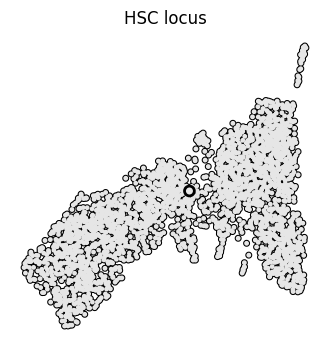

In [81]:
initial_locus = np.array([7.1,-8.1])
plot_order = adata.obs.index[np.argsort(adata[:,'Mpl'].X.toarray().flatten())]

fig, ax = plt.subplots(figsize=(4,4))
size = 12
ax.scatter(embedding['umap_1'], embedding['umap_2'], s =0.75*size, linewidth=2,facecolor='none',edgecolor='k')
ax.scatter(embedding['umap_1'], embedding['umap_2'], s=size, edgecolor='none', facecolor=[0.9,0.9,0.9])

plt.scatter(initial_locus[0],initial_locus[1],s=50,linewidth=2,marker='o', edgecolor='k',facecolor='none',alpha=1) 
plt.title('HSC locus')
sbn.despine(left=True, bottom=True)
plt.xticks([])
plt.yticks([])

Find the nearest cells to this locus on the embedding

In [82]:
n0 = 3
initial_cells = ((embedding - initial_locus)**2).sum(axis=1).sort_values().index[:n0].tolist()

In [83]:
initial_cells

['2727', '1829', '1484']

### Terminal states

Similarly, we choose some representative terminal loci for each lineage:

([], [])

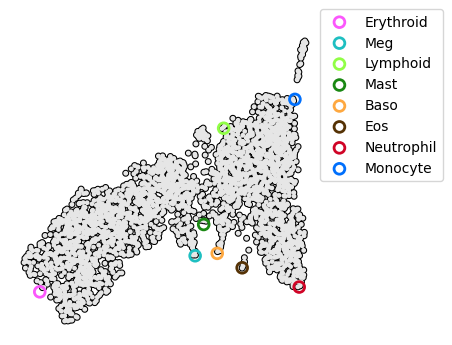

In [85]:
loci = [['Erythroid',  np.array([-3.4,-12.5])], 
        ['Meg',        np.array([7.5,-11])], 
        ['Lymphoid',   np.array([9.5,-5.7])],
        ['Mast',       np.array([8.1,-9.7])],
        ['Baso',       np.array([9.05, -10.9])],
        ['Eos',        np.array([10.8, -11.5])],
        ['Neutrophil', np.array([14.8,-12.3])],
        ['Monocyte',   np.array([14.5,-4.5])]]

fig, ax = plt.subplots(figsize=(4,4)) 

size = 12
ax.scatter(embedding['umap_1'], embedding['umap_2'], s =0.75*size, linewidth=2,facecolor='none',edgecolor='k')
ax.scatter(embedding['umap_1'], embedding['umap_2'], s=size, edgecolor='none', facecolor=[0.9,0.9,0.9])

for locus in loci:

    locus_label = locus[0]
    locus_coordinates_x,locus_coordinates_y = locus[1][0],locus[1][1]
    
    plt.scatter(locus_coordinates_x, locus_coordinates_y, s=5*size, linewidth=2,facecolor='none',color=cell_type_colors[locus_label], label=locus_label)
plt.legend(loc=[1,0.5])

sbn.despine(left=True, bottom=True)
plt.xticks([])
plt.yticks([])

Find cells nearest these points on the UMAP:

In [86]:
terminal_tips = {locus[0] : ((embedding[['umap_1', 'umap_2']] - locus[1])**2).sum(axis=1).sort_values().index[0] for locus in loci}

We pick 3 terminal cells within each lineage:

In [90]:
nFs = {locus[0] : 3 for locus in loci}

In [91]:
terminal_fates = []
terminal_cells = []
embedding_selection_df = embedding.copy()
print("Computing terminals for:")

for label in terminal_tips:
    print(label)
    loci_dists = ((embedding_selection_df - embedding.loc[terminal_tips[label]])**2).sum(axis=1).sort_values()

    indices = loci_dists.index[:nFs[label]].tolist()

    terminal_fates.append(indices)
    terminal_cells += indices
    embedding_selection_df = embedding_selection_df.drop(indices)


Computing terminals for:
Erythroid
Meg
Lymphoid
Mast
Baso
Eos
Neutrophil
Monocyte


In [94]:
fates = {loci[i][0] : terminal_fates[i] for i in range(len(terminal_fates))}
fates

cell_type_color_dict = {cell_types[i] : colors[i] for i in range(len(colors))}

### Visualizing the initial and terminal cells:

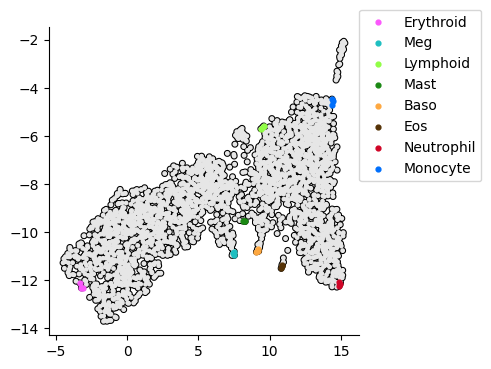

In [95]:
plt.figure(figsize=(4,4)) 

size = 12
plt.scatter(embedding['umap_1'], embedding['umap_2'], s =0.75*size, linewidth=2,facecolor='none',edgecolor='k')
plt.scatter(embedding['umap_1'], embedding['umap_2'], s=size, edgecolor='none', facecolor=[0.9,0.9,0.9])


for i in range(len(terminal_fates)):
    fate  = terminal_fates[i]
    label = loci[i][0]
    plt.scatter(embedding.loc[fate]['umap_1'],embedding.loc[fate]['umap_2'], s=size, color=cell_type_color_dict[label], label=label)
plt.legend(loc=[1,0.5])
sbn.despine()

[]

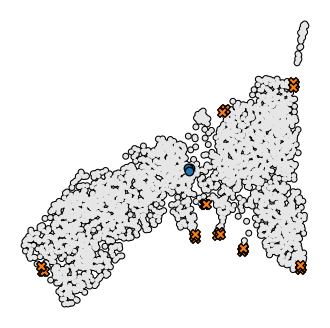

In [96]:
fig, ax = plt.subplots(figsize=(4,4))

size = 12
ax.scatter(embedding['umap_1'], embedding['umap_2'], s =0.75*size, linewidth=2,facecolor='none',edgecolor='k')
ax.scatter(embedding['umap_1'], embedding['umap_2'], s=size, edgecolor='none', facecolor=[0.9,0.9,0.9])


ax.scatter(embedding.loc[initial_cells,'umap_1'], embedding.loc[initial_cells,'umap_2'], s =1.5*25, color = 'tab:blue',  edgecolor='k',label='Initial')
ax.scatter(embedding.loc[terminal_cells, 'umap_1'], embedding.loc[terminal_cells,'umap_2'], s=2*25, color='tab:orange',marker='X', edgecolor='k',label='Terminal')


sbn.despine(left=True,bottom=True)

ax.set_xticks([])
ax.set_yticks([])
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
#plt.legend()

Create markers for initial and terminal states (for manuscript figure)

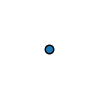

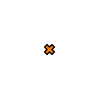

In [49]:
fig, ax = plt.subplots(figsize=(1,1))


ax.scatter(0.5,0.0, s =1.5*25, color = 'tab:blue',  edgecolor='k',label='Initial')

sbn.despine(left=True,bottom=True)

ax.set_xticks([])
ax.set_yticks([])
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])

plt.savefig(RESULTS_PATH + 'figures/{datestamp}_initial_marker.png'.format(datestamp=datestamp), dpi=600, transparent=True, bbox_inches='tight')



fig, ax = plt.subplots(figsize=(1,1))

 
ax.scatter(0.5,0.75, s=2*25, color='tab:orange',marker='X', edgecolor='k',label='Terminal') 


sbn.despine(left=True,bottom=True)

ax.set_xticks([])
ax.set_yticks([])
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])

plt.savefig(RESULTS_PATH + 'figures/{datestamp}_terminal_marker.png'.format(datestamp=datestamp), dpi=600, transparent=True, bbox_inches='tight')

### Apply MSOT

In [50]:
mmot = MMOT( root_indices     = initial_indices,
            terminal_indices     = terminal_indices,
            n_groups             = 20,
            epsilon              = 0.055
            )

mmot.fit(pca_df, verbose = True, patience  = 1000, tolerance = 1e-4)

## Perform additional proximal-point updates to reduce epsilon:
mmot.proximal_sinkhorn(epsilon_threshold=0.006, patience=1000)

 Iteration: 4000 [========] Max dual step: 3.734e-06 | Infeasibility: 6.496e-05 | Elapsed time: 0:11:52.217524

Sinkhorn algorithm converged to a solution within the given tolerance (1.0000e-04) of both feasibility and max dual-variable update step.


Retrieving transport plans...
Done.
Storing dual variables...
Done.
Max absolute feasibility errors in the marginal constraints: 
  {'mu_0': 0.0, 'mu_sum': 6.496201628558573e-05, 'max_mu_t': 3.6252281086848748e-06, 'mu_T': 6.280158225679955e-07}
 [Proximal Sinkhorn] Outer iterations: 9 | Initial epsilon: 5.5000e-02 | Current epsilon: 5.5000e-02 | Total epsilon: 5.5000e-03 | Elapsed time: 1:40:11.022730
 Terminating proximal scheme.


### Compute cell fate probabilities:

In [51]:
cell_fate_probabilities = mmot.cell_fate_probabilities(fates)

As in the synthetic data set, we graph the predicted cell fate probabilities using pie charts:

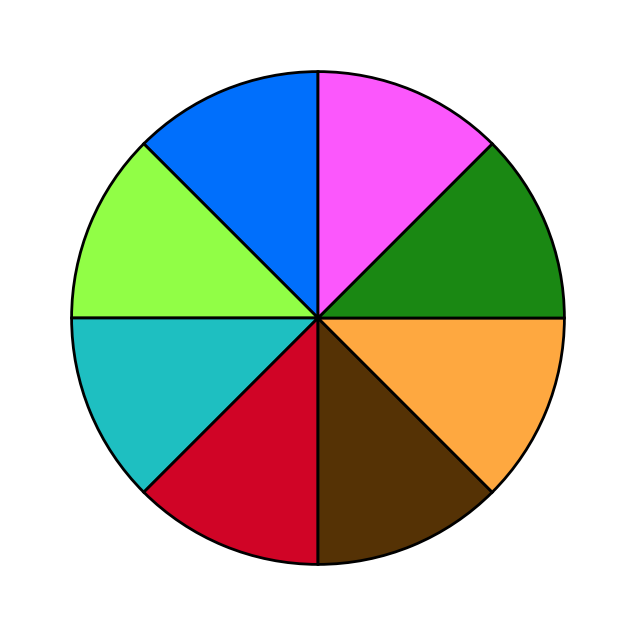

In [52]:
# Plot the pie chart
plt.figure(figsize=(8, 8))

values = np.array([1/cell_fate_probabilities.shape[1] for k in range(cell_fate_probabilities.shape[1])]) 

#test_values = [0.1, 0.2, 0.3, 0.4]
#test_colors = plt.get_cmap('Set3')([k for k in range(cell_fate_probabilities.shape[1])])

plt.pie(values, colors=colors,  
        startangle=90, 
        wedgeprops={ 'linewidth' : 2, 'edgecolor' : 'k',  'antialiased': True});

plt.savefig(RESULTS_PATH + "figures/{datestamp}_pie_chart.png".format(datestamp=datestamp), transparent=True, dpi=600, bbox_inches='tight')

Save cell fate probabilities and pseudotime

In [53]:
#cell_fate_probabilities.to_csv(RESULTS_PATH + "data/{datestamp}_cell_fate_probabilities.csv".format(datestamp=datestamp))
#mmot.pseudotemporal_order().to_csv(RESULTS_PATH + "data/{datestamp}_pseudotime.csv".format(datestamp=datestamp))

Load cell fate probabilities and pseudotime

In [30]:
cell_fate_probabilities = pd.read_csv(RESULTS_PATH + "data/{datestamp}_cell_fate_probabilities.csv".format(datestamp=datestamp))
cell_fate_probabilities.index = cell_fate_probabilities.iloc[:,0].values.astype(str)
cell_fate_probabilities = cell_fate_probabilities.drop("Unnamed: 0",axis=1)

Visualizing cell fate probabilities:

 Plotting cell nr 2730/2730

([], [])

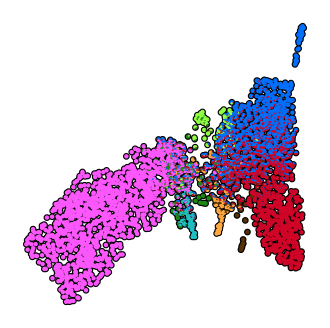

In [54]:
# Create the scatter plot
fig, ax = plt.subplots(figsize=(4,4)) 

np.random.seed(123)
tools.plot_fate_probabilities_with_pie_charts(ax,embedding,
                                cell_fate_probabilities.loc[embedding.index],
                                entropy_fade=False, frac=1, plot_order=cell_types, colors=colors, s=12, background=11)

# Show the plot
sbn.despine(left=True, bottom=True)
ax.get_legend().remove()
plt.xticks([])
plt.yticks([])
#plt.savefig(RESULTS_PATH + 'figures/{datestamp}_cell_fate_probabilities.png'.format(datestamp=datestamp), dpi=600, transparent=True, bbox_inches='tight')

Zooming in on initial states:

 Plotting cell nr 3/3

([], [])

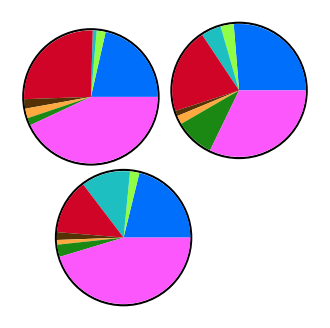

In [55]:
# Create the scatter plot
fig, ax = plt.subplots(figsize=(4,4)) 

np.random.seed(123)
tools.plot_fate_probabilities_with_pie_charts(ax,embedding.loc[initial_indices],
                                cell_fate_probabilities.loc[initial_indices],
                                entropy_fade=False, frac=1, indices=initial_indices, plot_order=cell_types, colors=colors, s=38000, background=9500)

# Show the plot
sbn.despine(left=True, bottom=True)
ax.get_legend().remove()
plt.xticks([])
plt.yticks([])
#plt.savefig(RESULTS_PATH + 'figures/{datestamp}_cell_fate_probabilities_initial_cells.png'.format(datestamp=datestamp), dpi=600, transparent=True, bbox_inches='tight')

Comparing predicted fates to a layered representation of lineage-associated markers

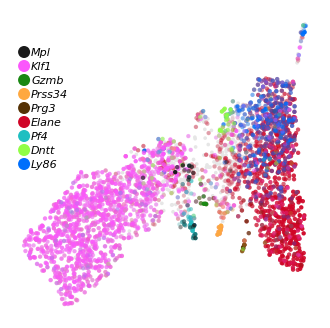

In [56]:
import matplotlib.font_manager as font_manager


font = font_manager.FontProperties(style='italic')

fig, ax1 = plt.subplots(figsize=(4,4))

gene_list = ['Ly86','Dntt','Pf4','Elane','Prg3','Prss34','Gzmb','Klf1','Mpl']

annotation_colors = np.concatenate((colors, np.array([[0.1,0.1,0.1]])),axis=0)

zorder = [3,9,10,1,4,8,11,7,12]

data_z_scores = pd.DataFrame(adata.X, index=adata.obs.index, columns=adata.var_names)
data_z_scores = (data_z_scores - data_z_scores.mean()) / data_z_scores.std()

#Normalize embedding to unit square:
embedding = (embedding - embedding.min()) / (embedding.max() - embedding.min())

#ax1.scatter(embedding['umap_1'],embedding['umap_2'], facecolor='none', edgecolor='k',s = 10,zorder=-1)
ax1.scatter(embedding['umap_1'],embedding['umap_2'], facecolor=[0.9,0.9,0.9], edgecolor='none',s = 7,zorder=0) 

for i in range(len(gene_list)):
    
    gene_exp = data_z_scores[gene_list[i]]
    plot_order = gene_exp.sort_values(ascending=True).index
    gene_exp_sorted = gene_exp.loc[plot_order]
    
    alpha = (gene_exp_sorted - np.min(gene_exp_sorted) ) / (np.max(gene_exp_sorted) - np.min(gene_exp_sorted) )
    ax1.scatter(embedding.loc[plot_order]['umap_1'],embedding.loc[plot_order]['umap_2'], s=10, alpha=alpha, facecolor=annotation_colors[i], edgecolor='none',zorder=zorder[i])
    ax1.scatter(0,0.05*i+0.5, s=75,  facecolor=annotation_colors[i], edgecolor='none',zorder=zorder[i])

    #Plot gene names:
    ax1.text(0.025,0.05*i-0.015+0.5, gene_list[i], fontproperties=font, fontsize=8)

sbn.despine(left=True, bottom=True)
plt.xticks([])
plt.yticks([])
plt.savefig(RESULTS_PATH + "figures/{datestamp}_annotation_with_gene_expression.png".format(datestamp=datestamp), transparent=True,dpi=600, bbox_inches='tight')

Plotting each lineage separately:

[0.         0.43529412 0.98823529]
[0.56862745 0.99607843 0.2745098 ]
[0.11764706 0.74901961 0.75686275]
[0.81568627 0.01568627 0.14901961]
[0.33333333 0.19607843 0.01960784]
[0.99607843 0.65882353 0.25098039]
[0.10196078 0.53333333 0.0745098 ]
[0.98431373 0.34117647 0.98823529]
[0.1 0.1 0.1]


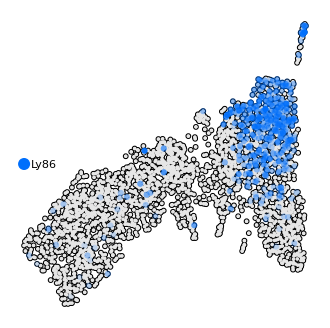

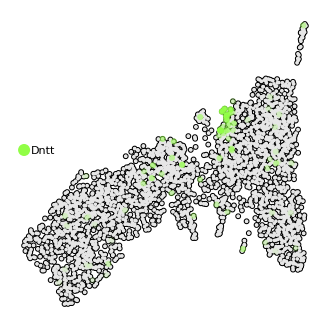

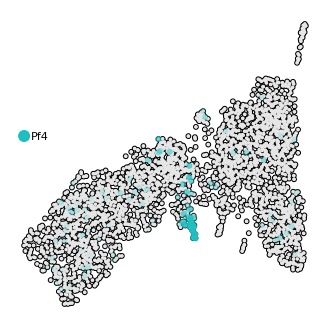

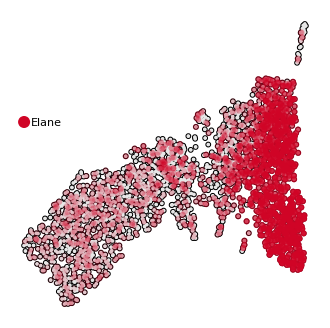

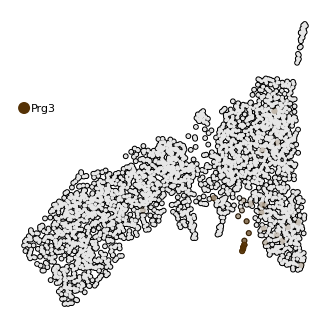

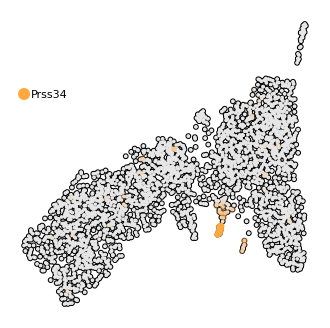

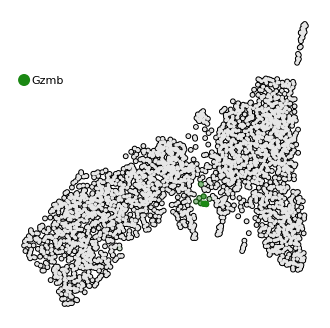

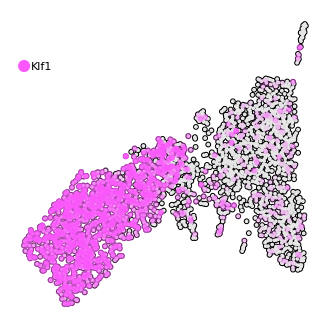

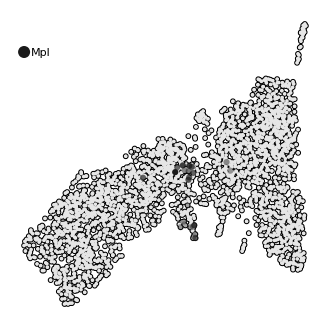

In [57]:
#Normalize embedding to unit square:
embedding = (embedding - embedding.min()) / (embedding.max() - embedding.min())
for i in range(len(gene_list)):
        
    fig, ax1 = plt.subplots(figsize=(4,4))

    ax1.scatter(embedding['umap_1'],embedding['umap_2'], facecolor='none', edgecolor='k',s = 10,zorder=-1)
    ax1.scatter(embedding['umap_1'],embedding['umap_2'], facecolor=[0.9,0.9,0.9], edgecolor='none',s = 7,zorder=0) 

    gene_list = ['Ly86','Dntt','Pf4','Elane','Prg3','Prss34','Gzmb','Klf1','Mpl']

    annotation_colors = np.concatenate((colors, np.array([[0.1,0.1,0.1]])),axis=0)

    zorder = [3,9,2,1,4,8,10,7,100]

    data_z_scores = pd.DataFrame(adata.X, index=adata.obs.index, columns=adata.var_names)
    data_z_scores = (data_z_scores - data_z_scores.mean()) / data_z_scores.std()

    

        
    gene_exp = data_z_scores[gene_list[i]]
    plot_order = gene_exp.sort_values(ascending=True).index
    gene_exp_sorted = gene_exp.loc[plot_order]
    
    alpha = (gene_exp_sorted - np.min(gene_exp_sorted) ) / (np.max(gene_exp_sorted) - np.min(gene_exp_sorted) )
    print(annotation_colors[i])
    ax1.scatter(embedding.loc[plot_order]['umap_1'],embedding.loc[plot_order]['umap_2'], s=20, alpha=alpha, facecolor=annotation_colors[i], edgecolor='none',zorder=zorder[i])
    ax1.scatter(0,0.05*i+0.5, s=75,  facecolor=annotation_colors[i], edgecolor='none',zorder=zorder[i])
    ax1.text(0.025,0.05*i-0.015+0.5, gene_list[i], fontsize=8)

    sbn.despine(left=True, bottom=True)
    plt.xticks([])
    plt.yticks([])
#plt.savefig("{datestamp}_annotation_with_gene_expression.png".format(datestamp=datestamp), transparent=True,dpi=600, bbox_inches='tight')

### Pseudotemporal ordering

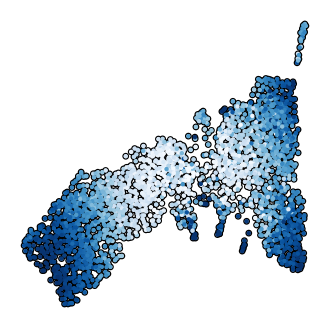

In [58]:
fig, ax = plt.subplots(figsize=(4,4))
pt_order = mmot.pseudotemporal_order()
plt.scatter(adata[pt_order.index].obsm['X_umap'][:,0],adata[pt_order.index].obsm['X_umap'][:,1],s=15, facecolor='none',edgecolor='k')
plt.scatter(adata[pt_order.index].obsm['X_umap'][:,0],adata[pt_order.index].obsm['X_umap'][:,1],s=10, edgecolor='none',c=pt_order, cmap='Blues')

sbn.despine(left=True,bottom=True)
plt.xticks([])
plt.yticks([])
plt.savefig(RESULTS_PATH + 'figures/{datestamp}_pseudotime.png'.format(datestamp=datestamp), dpi=600, transparent=True, bbox_inches='tight')

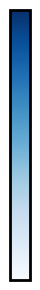

In [71]:
import matplotlib

fig = plt.figure(figsize=(8, 3))
ax = fig.add_axes([0., 0., 0.025, 0.9])

cb_outliers = matplotlib.colorbar.ColorbarBase(ax, cmap='Blues', 
                                orientation='vertical')
cb_outliers.set_ticks([])
cb_outliers.outline.set_linewidth(2)
 
 
cb_outliers.set_ticklabels([])
plt.savefig(RESULTS_PATH + 'figures/{datestamp}_pseudotime_colorbar.png'.format(datestamp=datestamp), transparent=True,dpi=600,bbox_inches='tight')
plt.show()

### Repeat with a different number of cells in the Erythroid lineage

In [72]:
embedding = pd.DataFrame(adata.obsm['X_umap'],index=adata.obs.index,columns=['umap_1','umap_2'])

We create two new loci for the Erythroid fate

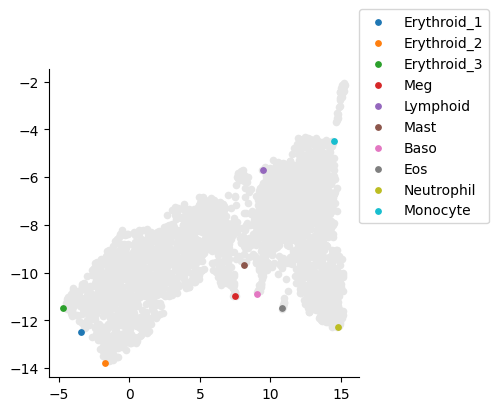

In [73]:
loci = [['Erythroid_1',  np.array([-3.4,-12.5])], 
        ['Erythroid_2',  np.array([-1.75,-13.8])],
        ['Erythroid_3',  np.array([-4.7,-11.5])],
        ['Meg',        np.array([7.5,-11])], 
        ['Lymphoid',   np.array([9.5,-5.7])],
        ['Mast',       np.array([8.1,-9.7])],
        ['Baso',       np.array([9.05, -10.9])],
        ['Eos',        np.array([10.8, -11.5])],
        ['Neutrophil', np.array([14.8,-12.3])],
        ['Monocyte',   np.array([14.5,-4.5])]]


gene = 'Procr'

plt.figure(figsize=(4,4))
plt.scatter(embedding['umap_1'],embedding['umap_2'], color=[0.9,0.9,0.9], s = 20) 

size = 15
for locus in loci:

    locus_label = locus[0]
    locus_coordinates_x,locus_coordinates_y = locus[1][0],locus[1][1]
    
    plt.scatter(locus_coordinates_x, locus_coordinates_y, s=size,  label=locus_label)
plt.legend(loc=[1,0.5])
sbn.despine()

In [74]:
terminal_tips = {locus[0] : ((embedding[['umap_1', 'umap_2']] - locus[1])**2).sum(axis=1).sort_values().index[0] for locus in loci}

The erythroid lineages get a total of 30 terminal cells, 10x the cells in the number of cells in other lineages

In [75]:
nTs = {locus[0] : 3 for locus in loci}

nTs['Erythroid_1'] = 10
nTs['Erythroid_2'] = 10
nTs['Erythroid_3'] = 10

In [76]:
terminal_fates = []
terminal_indices = []
embedding_selection_df = embedding.copy()
print("Computing terminals for:")

for label in terminal_tips:
    print(label)
    loci_dists = ((embedding_selection_df - embedding.loc[terminal_tips[label]])**2).sum(axis=1).sort_values()

    indices = loci_dists.index[:nTs[label]].tolist()

    terminal_fates.append(indices)
    terminal_indices += indices
    embedding_selection_df = embedding_selection_df.drop(indices)


Computing terminals for:
Erythroid_1
Erythroid_2
Erythroid_3
Meg
Lymphoid
Mast
Baso
Eos
Neutrophil
Monocyte


### Visualizing new initial and terminal states

[]

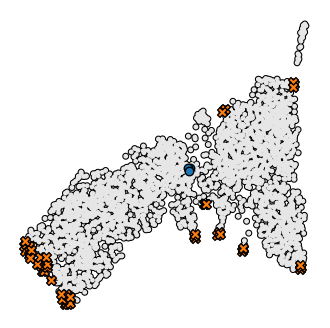

In [77]:
fig, ax = plt.subplots(figsize=(4,4))

size = 12
ax.scatter(embedding['umap_1'], embedding['umap_2'], s =0.75*size, linewidth=2,facecolor='none',edgecolor='k')
ax.scatter(embedding['umap_1'], embedding['umap_2'], s=size, edgecolor='none', facecolor=[0.9,0.9,0.9])


ax.scatter(embedding.loc[initial_indices,'umap_1'], embedding.loc[initial_indices,'umap_2'], s =1.5*25, color = 'tab:blue',  edgecolor='k',label='Initial')
ax.scatter(embedding.loc[terminal_indices, 'umap_1'], embedding.loc[terminal_indices,'umap_2'], s=2*25, color='tab:orange',marker='X', edgecolor='k',label='Terminal')


sbn.despine(left=True,bottom=True)

ax.set_xticks([])
ax.set_yticks([])
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])


In [44]:
mmot_ery = MMOT( root_indices     = initial_indices,
            terminal_indices     = terminal_indices,
            n_groups             = 20,
            epsilon              = 0.055
            )

mmot_ery.fit(pca_df, verbose = True, patience  = 1000, tolerance = 1e-4)

## Perform additional proximal-point updates to reduce epsilon:
mmot_ery.proximal_sinkhorn(epsilon_threshold=0.006, patience=1000)

 Iteration: 4000 [========] Max dual step: 4.601e-06 | Infeasibility: 8.024e-05 | Elapsed time: 0:11:46.441561

Sinkhorn algorithm converged to a solution within the given tolerance (1.0000e-04) of both feasibility and max dual-variable update step.


Retrieving transport plans...
Done.
Storing dual variables...
Done.
Max absolute feasibility errors in the marginal constraints: 
  {'mu_0': 0.0, 'mu_sum': 8.024350091406784e-05, 'max_mu_t': 4.462163488816451e-06, 'mu_T': 7.424255682453307e-07}
 [Proximal Sinkhorn] Outer iterations: 9 | Initial epsilon: 5.5000e-02 | Current epsilon: 5.5000e-02 | Total epsilon: 5.5000e-03 | Elapsed time: 1:10:31.869285
 Terminating proximal scheme.


Update fate and color dictionaries

In [46]:
fates = {loci[i][0] : terminal_fates[i] for i in range(len(terminal_fates))}

#Aggregate the terminal cells in the Erythroid lineage:
fates['Erythroid'] = fates['Erythroid_1'] + fates['Erythroid_2'] + fates['Erythroid_3']
fates.pop('Erythroid_1')
fates.pop('Erythroid_2')
fates.pop('Erythroid_3')
cell_type_color_dict = {cell_types[i] : colors[i] for i in range(len(colors))}

### Cell fate probabilities

In [47]:
cell_fate_probabilities = mmot_ery.cell_fate_probabilities(fates)

 Plotting cell nr 2730/2730

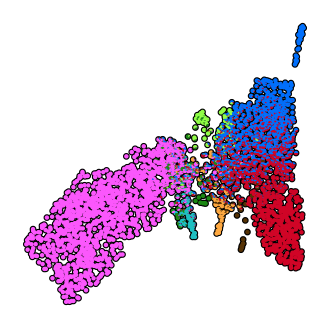

In [48]:
# Create the scatter plot
fig, ax = plt.subplots(figsize=(4,4)) 

np.random.seed(123)
tools.plot_fate_probabilities_with_pie_charts(ax,embedding,
                                cell_fate_probabilities.loc[embedding.index],
                                entropy_fade=False, frac=1, plot_order=cell_types, colors=colors, s=12, background=11)

# Show the plot
sbn.despine(left=True, bottom=True)
ax.get_legend().remove()
plt.xticks([])
plt.yticks([])
plt.savefig(RESULTS_PATH + 'figures/{datestamp}_cell_fate_probabilities_many_ery.png'.format(datestamp=datestamp), dpi=600, transparent=True, bbox_inches='tight')

([], [])

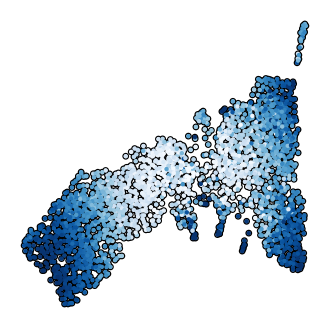

In [49]:
fig, ax = plt.subplots(figsize=(4,4))
pt_order = mmot.pseudotemporal_order()
plt.scatter(adata[pt_order.index].obsm['X_umap'][:,0],adata[pt_order.index].obsm['X_umap'][:,1],s=15, facecolor='none',edgecolor='k')
plt.scatter(adata[pt_order.index].obsm['X_umap'][:,0],adata[pt_order.index].obsm['X_umap'][:,1],s=10, edgecolor='none',c=pt_order, cmap='Blues')

sbn.despine(left=True,bottom=True)
plt.xticks([])
plt.yticks([])


 Plotting cell nr 3/3

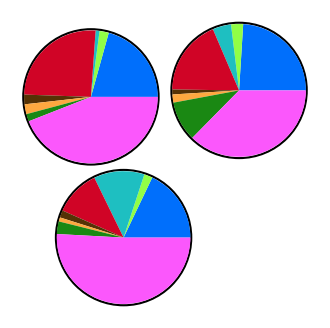

In [50]:
# Create the scatter plot
fig, ax = plt.subplots(figsize=(4,4)) 

np.random.seed(123)
tools.plot_fate_probabilities_with_pie_charts(ax,embedding.loc[initial_indices],
                                cell_fate_probabilities.loc[initial_indices],
                                entropy_fade=False, frac=1, indices=initial_indices, plot_order=cell_types, colors=colors, s=38000, background=9500)

# Show the plot
sbn.despine(left=True, bottom=True)
ax.get_legend().remove()
plt.xticks([])
plt.yticks([])
plt.savefig(RESULTS_PATH + 'figures/{datestamp}_cell_fate_probabilities_initial_cells_many_ery.png'.format(datestamp=datestamp), dpi=600, transparent=True, bbox_inches='tight')

Save cell fate probabilities:

In [51]:
cell_fate_probabilities.to_csv(RESULTS_PATH + "data/{datestamp}_cell_fate_probabilities_many_ery.csv".format(datestamp=datestamp))
mmot_ery.pseudotemporal_order().to_csv(RESULTS_PATH + "data/{datestamp}_pseudotime_many_ery.csv".format(datestamp=datestamp))

Conclusion: solution is not identical but similar to the case where there were 3, as opposed to 30, cells in the Erythroid fate.

### Quantifying the difference in downstream results

Load results

In [129]:
cell_fate_probabilities = pd.read_csv(RESULTS_PATH + "data/{datestamp}_cell_fate_probabilities.csv".format(datestamp=datestamp))
cell_fate_probabilities_many_ery = pd.read_csv(RESULTS_PATH + "data/{datestamp}_cell_fate_probabilities_many_ery.csv".format(datestamp=datestamp))

cell_fate_probabilities.index = cell_fate_probabilities.iloc[:,0].values
cell_fate_probabilities = cell_fate_probabilities.drop("Unnamed: 0",axis=1)
cell_fate_probabilities_many_ery.index = cell_fate_probabilities_many_ery.iloc[:,0].values
cell_fate_probabilities_many_ery = cell_fate_probabilities_many_ery.drop("Unnamed: 0",axis=1)
cell_fate_probabilities_many_ery = cell_fate_probabilities_many_ery[cell_fate_probabilities.columns]

In [130]:
TV = (0.5*(cell_fate_probabilities - cell_fate_probabilities_many_ery).abs().sum(axis=1))

In [131]:
print("TV (+- std. error): {tv} +- {sem}".format(tv=TV.mean(), sem=TV.std()/np.sqrt(TV.shape[0])))

TV (+- std. error): 0.021752723756143955 +- 0.0010649984051249624


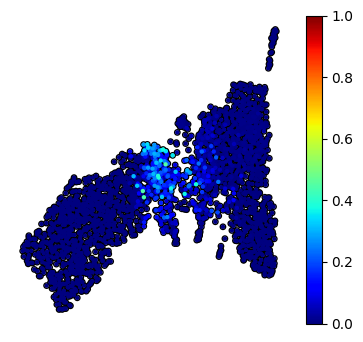

In [133]:
fig, ax = plt.subplots(figsize=(4.5,4))
plot_order = TV.sort_values().index
plt.scatter(adata[plot_order].obsm['X_umap'][:,0],adata[plot_order].obsm['X_umap'][:,1],s=15, facecolor='none',edgecolor='k')
plt.scatter(adata[plot_order].obsm['X_umap'][:,0],adata[plot_order].obsm['X_umap'][:,1],s=10, edgecolor='none',c=TV.loc[plot_order], vmax=1, cmap='jet')

sbn.despine(left=True,bottom=True)
plt.xticks([])
plt.yticks([])
plt.colorbar()

In [56]:
pseudotime = pd.read_csv(RESULTS_PATH + "data/{datestamp}_pseudotime.csv".format(datestamp=datestamp))
pseudotime_many_ery = pd.read_csv(RESULTS_PATH + "data/{datestamp}_pseudotime_many_ery.csv".format(datestamp=datestamp))

pseudotime.index = pseudotime.iloc[:,0].values
pseudotime = pseudotime.drop("Unnamed: 0",axis=1)
pseudotime_many_ery.index = pseudotime_many_ery.iloc[:,0].values
pseudotime_many_ery = pseudotime_many_ery.drop("Unnamed: 0",axis=1) 

In [83]:
pt_error = (pseudotime - pseudotime_many_ery).abs()

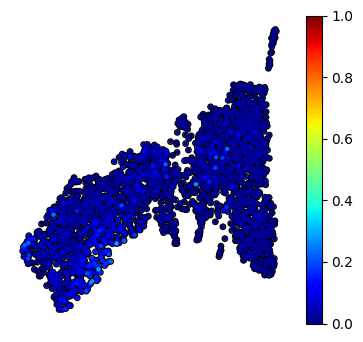

In [128]:
fig, ax = plt.subplots(figsize=(4.5,4))
plot_order = pt_error.sort_values(by='mmot_pseudotime_order').index
plt.scatter(adata[plot_order].obsm['X_umap'][:,0],adata[plot_order].obsm['X_umap'][:,1],s=15, facecolor='none',edgecolor='k')
plt.scatter(adata[plot_order].obsm['X_umap'][:,0],adata[plot_order].obsm['X_umap'][:,1],s=10, edgecolor='none',c=pt_error.loc[plot_order].values, cmap='jet', vmax=1)

sbn.despine(left=True,bottom=True)
plt.xticks([])
plt.yticks([])
plt.colorbar()

### 10 and 30 differentiation stages (instead of 20)

In [516]:
loci = [['Erythroid',  np.array([-3.4,-12.5])], 
        ['Meg',        np.array([7.5,-11])], 
        ['Lymphoid',   np.array([9.5,-5.7])],
        ['Mast',       np.array([8.1,-9.7])],
        ['Baso',       np.array([9.05, -10.9])],
        ['Eos',        np.array([10.8, -11.5])],
        ['Neutrophil', np.array([14.8,-12.3])],
        ['Monocyte',   np.array([14.5,-4.5])]]

In [517]:
terminal_tips = {locus[0] : ((embedding[['umap_1', 'umap_2']] - locus[1])**2).sum(axis=1).sort_values().index[0] for locus in loci}

In [518]:
nTs = {locus[0] : 3 for locus in loci}

In [519]:
terminal_fates = []
terminal_indices = []
embedding_selection_df = embedding.copy()
print("Computing terminals for:")

for label in terminal_tips:
    print(label)
    loci_dists = ((embedding_selection_df - embedding.loc[terminal_tips[label]])**2).sum(axis=1).sort_values()

    indices = loci_dists.index[:nTs[label]].tolist()

    terminal_fates.append(indices)
    terminal_indices += indices
    embedding_selection_df = embedding_selection_df.drop(indices)


Computing terminals for:
Erythroid
Meg
Lymphoid
Mast
Baso
Eos
Neutrophil
Monocyte


[]

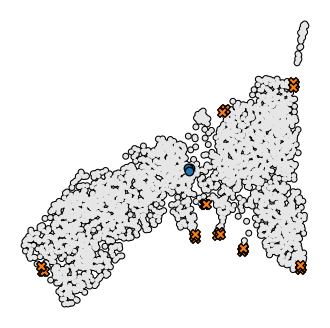

In [520]:
fig, ax = plt.subplots(figsize=(4,4))

size = 12
ax.scatter(embedding['umap_1'], embedding['umap_2'], s =0.75*size, linewidth=2,facecolor='none',edgecolor='k')
ax.scatter(embedding['umap_1'], embedding['umap_2'], s=size, edgecolor='none', facecolor=[0.9,0.9,0.9])


ax.scatter(embedding.loc[initial_indices,'umap_1'], embedding.loc[initial_indices,'umap_2'], s =1.5*25, color = 'tab:blue',  edgecolor='k',label='Initial')
ax.scatter(embedding.loc[terminal_indices, 'umap_1'], embedding.loc[terminal_indices,'umap_2'], s=2*25, color='tab:orange',marker='X', edgecolor='k',label='Terminal')


sbn.despine(left=True,bottom=True)

ax.set_xticks([])
ax.set_yticks([])
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
#plt.legend() 

In [521]:
fates = {loci[i][0] : terminal_fates[i] for i in range(len(terminal_fates))}


cell_type_color_dict = {cell_types[i] : colors[i] for i in range(len(colors))}

In [522]:
for n_stages in [10,30]:
    mmot_experiment = MMOT( root_indices    = initial_indices,
                    terminal_indices     = terminal_indices,
                    n_groups             = n_stages,
                    epsilon              = 0.055
                    )

    mmot_experiment.fit(pca_df, verbose = True, patience  = 1000, tolerance = 1e-4)

    ## Perform additional proximal-point updates to reduce epsilon:
    mmot_experiment.proximal_sinkhorn(epsilon_threshold=0.006, patience=1000)

    cell_fate_probabilities = mmot_experiment.cell_fate_probabilities(fates)
    cell_fate_probabilities.to_csv(RESULTS_PATH + "data/{datestamp}_cell_fate_probabilities_{T}_stages_experiment.csv".format(datestamp=datestamp,T=n_stages))
    mmot_experiment.pseudotemporal_order().to_csv(RESULTS_PATH + "data/{datestamp}_pseudotime_{T}_stages_experiment.csv".format(datestamp=datestamp,T=n_stages))

 Iteration: 6000 [========] Max dual step: 3.074e-07 | Infeasibility: 5.473e-06 | Elapsed time: 0:10:32.184995

Sinkhorn algorithm converged to a solution within the given tolerance (1.0000e-04) of both feasibility and max dual-variable update step.


Retrieving transport plans...
Done.
Storing dual variables...
Done.
Max absolute feasibility errors in the marginal constraints: 
  {'mu_0': 0.0, 'mu_sum': 5.4733712138155255e-06, 'max_mu_t': 1.0883083151891348e-06, 'mu_T': 3.576925888815197e-08}
 [Proximal Sinkhorn] Outer iterations: 9 | Initial epsilon: 5.5000e-02 | Current epsilon: 5.5000e-02 | Total epsilon: 5.5000e-03 | Elapsed time: 0:31:50.671978
 Terminating proximal scheme.
 Iteration: 11000 [========] Max dual step: 4.177e-06 | Infeasibility: 7.526e-05 | Elapsed time: 0:56:51.570431

Sinkhorn algorithm converged to a solution within the given tolerance (1.0000e-04) of both feasibility and max dual-variable update step.


Retrieving transport plans...
Done.
Storing dual variables

In [542]:
cell_fate_probabilities = pd.read_csv(RESULTS_PATH + "data/{datestamp}_cell_fate_probabilities.csv".format(datestamp=datestamp))
cell_fate_probabilities_10_stages = pd.read_csv(RESULTS_PATH + "data/{datestamp}_cell_fate_probabilities_10_stages_experiment.csv".format(datestamp=datestamp))
cell_fate_probabilities_30_stages = pd.read_csv(RESULTS_PATH + "data/{datestamp}_cell_fate_probabilities_30_stages_experiment.csv".format(datestamp=datestamp))

cell_fate_probabilities.index = cell_fate_probabilities.iloc[:,0].values
cell_fate_probabilities = cell_fate_probabilities.drop("Unnamed: 0",axis=1)
cell_fate_probabilities_10_stages.index = cell_fate_probabilities_10_stages.iloc[:,0].values.astype(str)
cell_fate_probabilities_10_stages = cell_fate_probabilities_10_stages.drop("Unnamed: 0",axis=1)
cell_fate_probabilities_10_stages = cell_fate_probabilities_10_stages[cell_fate_probabilities.columns]
cell_fate_probabilities_30_stages.index = cell_fate_probabilities_30_stages.iloc[:,0].values.astype(str)
cell_fate_probabilities_30_stages = cell_fate_probabilities_30_stages.drop("Unnamed: 0",axis=1)
cell_fate_probabilities_30_stages = cell_fate_probabilities_30_stages[cell_fate_probabilities.columns]

In [543]:
cell_fate_probabilities.index = cell_fate_probabilities.index.astype(str)
TV = (0.5*(cell_fate_probabilities - cell_fate_probabilities_10_stages[cell_fate_probabilities.columns]).abs().sum(axis=1))

In [544]:
print("TV (+- std. error): {tv} +- {sem}".format(tv=TV.mean(), sem=TV.std()/np.sqrt(TV.shape[0])))

TV (+- std. error): 0.09014875110286036 +- 0.002695406362687052


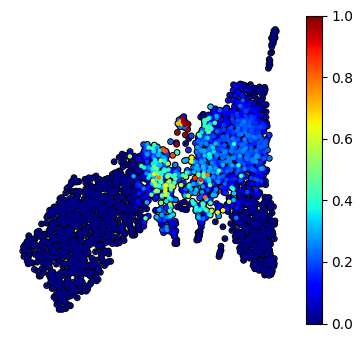

In [545]:
fig, ax = plt.subplots(figsize=(4.5,4))
plot_order = TV.sort_values().index
plt.scatter(adata[plot_order].obsm['X_umap'][:,0],adata[plot_order].obsm['X_umap'][:,1],s=15, facecolor='none',edgecolor='k')
plt.scatter(adata[plot_order].obsm['X_umap'][:,0],adata[plot_order].obsm['X_umap'][:,1],s=10, edgecolor='none',c=TV.loc[plot_order], cmap='jet', vmax=1)

sbn.despine(left=True,bottom=True)
plt.xticks([])
plt.yticks([])
plt.colorbar()

In [547]:
cell_fate_probabilities.index = cell_fate_probabilities.index.astype(str)
TV = (0.5*(cell_fate_probabilities - cell_fate_probabilities_30_stages[cell_fate_probabilities.columns]).abs().sum(axis=1))

In [548]:
print("TV (+- std. error): {tv} +- {sem}".format(tv=TV.mean(), sem=TV.std()/np.sqrt(TV.shape[0])))

TV (+- std. error): 0.05464685328331558 +- 0.0015683049339360884


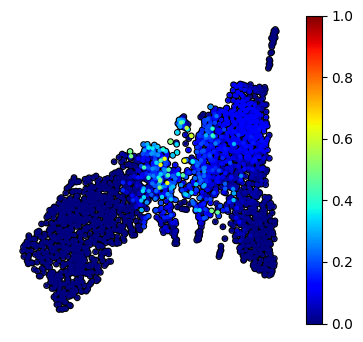

In [549]:
fig, ax = plt.subplots(figsize=(4.5,4))
plot_order = TV.sort_values().index
plt.scatter(adata[plot_order].obsm['X_umap'][:,0],adata[plot_order].obsm['X_umap'][:,1],s=15, facecolor='none',edgecolor='k')
plt.scatter(adata[plot_order].obsm['X_umap'][:,0],adata[plot_order].obsm['X_umap'][:,1],s=10, edgecolor='none',c=TV.loc[plot_order], cmap='jet', vmax=1)

sbn.despine(left=True,bottom=True)
plt.xticks([])
plt.yticks([])
plt.colorbar()